In [2]:
!pip install kagglehub lime scikit-image opencv-python matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("✅ TensorFlow:", tf.__version__)


✅ TensorFlow: 2.19.0


In [4]:
print("Setting up dataset path...")
dataset_path = None
try:
    import kagglehub
    dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
    print('✅ Dataset downloaded via KaggleHub.')
except Exception as e:
    print('⚠️ KaggleHub not available or failed:', e)

repo_data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'brain-tumor-mri-dataset'))
if os.path.isdir(repo_data_path):
    dataset_path = repo_data_path

if not dataset_path:
    raise RuntimeError("Dataset path not found. Install kagglehub or place dataset manually.")

print('📂 Using dataset_path =', dataset_path)

train_dir = os.path.join(dataset_path, 'Training')
test_dir  = os.path.join(dataset_path, 'Testing')


Setting up dataset path...
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
✅ Dataset downloaded via KaggleHub.
📂 Using dataset_path = /kaggle/input/brain-tumor-mri-dataset


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True)
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # freeze backbone initially

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      8,196 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:

EPOCHS = 20  # increased from 8 → 20

callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_resnet50.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(val_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Epoch 1/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9251 - loss: 0.2028
Epoch 1: val_accuracy improved from -inf to 0.90008, saving model to best_resnet50.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9250 - loss: 0.2029 - val_accuracy: 0.9001 - val_loss: 0.2632
Epoch 2/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9215 - loss: 0.2066
Epoch 2: val_accuracy improved from 0.90008 to 0.90770, saving model to best_resnet50.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9215 - loss: 0.2066 - val_accuracy: 0.9077 - val_loss: 0.2465
Epoch 3/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9292 - loss: 0.1807
Epoch 3: val_accuracy improved from 0.90770 to 0.91762, saving model to best_resnet50.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9292 - loss: 0.1807 - val_accuracy: 0.9176 - val_loss: 0.2074
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9273 - loss: 0.1930
Epoch 4: val_accuracy did not improve from 0.91762
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9273 - loss: 0.1930 - val_accuracy: 0.9146 - val_loss: 0.2168
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9324 - loss: 0.1730
Epoch 5: val_accuracy did not improve from 0.91762
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9324 - loss: 0.1730 - val_accuracy: 0.9146 - val_loss: 0.2172
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9398 - loss: 0.1648
Epoch 6: val_accuracy did not improve from 0.91762
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9398 - loss: 0.1648 - val_accuracy: 0.9153 - val_loss: 0.2196
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9406 - loss: 0.1595
Epoch 7: val_accuracy d

357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9422 - loss: 0.1482 - val_accuracy: 0.9283 - val_loss: 0.2041
Epoch 9/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9443 - loss: 0.1580
Epoch 9: val_accuracy did not improve from 0.92830
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9443 - loss: 0.1579 - val_accuracy: 0.9245 - val_loss: 0.2002
Epoch 10/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9520 - loss: 0.1328
Epoch 10: val_accuracy improved from 0.92830 to 0.93593, saving model to best_resnet50.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9520 - loss: 0.1328 - val_accuracy: 0.9359 - val_loss: 0.1666
Epoch 11/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9407 - loss: 0.1438
Epoch 11: val_accuracy improved from 0.93593 to 0.93669, saving model to best_resnet50.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9407 - loss: 0.1439 - val_accuracy: 0.9367 - val_loss: 0.1843
Epoch 12/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9469 - loss: 0.1502
Epoch 12: val_accuracy did not improve from 0.93669
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9469 - loss: 0.1502 - val_accuracy: 0.9329 - val_loss: 0.1709
Epoch 13/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9489 - loss: 0.1419
Epoch 13: val_accuracy did not improve from 0.93669
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9489 - loss: 0.1419 - val_accuracy: 0.9359 - val_loss: 0.1913
Epoch 14/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9457 - loss: 0.1383
Epoch 14: val_accuracy did not improve from 0.93669
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9457 - loss: 0.1383 - val_accuracy: 0.9245 - val_loss: 0.2104
Epoch 15/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9449 - loss: 0.1465
Epoch 15: val_ac

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


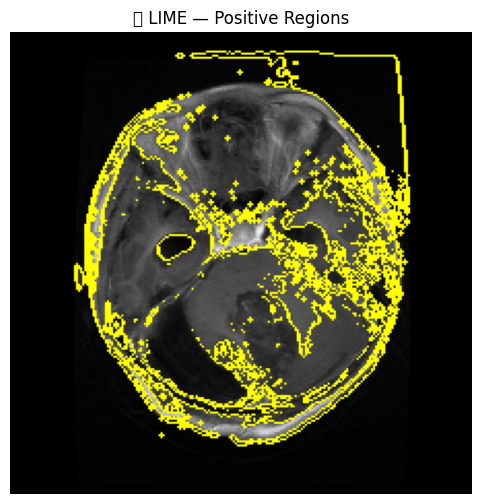

In [9]:
for imgs, labels in val_ds.take(1):
    sample_img = imgs[0].numpy().astype('uint8')
    break

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    imgs = np.array(images, dtype=np.float32)
    imgs = tf.keras.applications.resnet50.preprocess_input(imgs)
    return model.predict(imgs)

explanation = explainer.explain_instance(
    sample_img.astype('double'),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=8,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.title("🧠 LIME — Positive Regions")
plt.axis("off")
plt.show()


In [10]:
def score_cam(img_array, model, layer_name, preprocess_input, upsample_size=(224,224)):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    conv_outputs, preds = grad_model(img_array)
    conv_outputs = conv_outputs[0].numpy()
    pred_class = np.argmax(preds[0])

    act_maps = np.maximum(conv_outputs, 0)
    act_maps = act_maps / (act_maps.max(axis=(0,1)) + 1e-8)

    score_map = np.zeros(act_maps.shape[:2], dtype=np.float32)
    for i in range(act_maps.shape[-1]):
        upsampled = cv2.resize(act_maps[:,:,i], upsample_size)
        upsampled = np.expand_dims(upsampled, (0,-1))
        pred = model.predict(preprocess_input(img_array * upsampled))
        score_map += upsampled[0,:,:,0] * pred[0,pred_class]

    score_map = np.maximum(score_map, 0)
    score_map /= (score_map.max() + 1e-8)
    return score_map, pred_class


✅ Using last conv layer inside ResNet: conv5_block3_3_conv


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


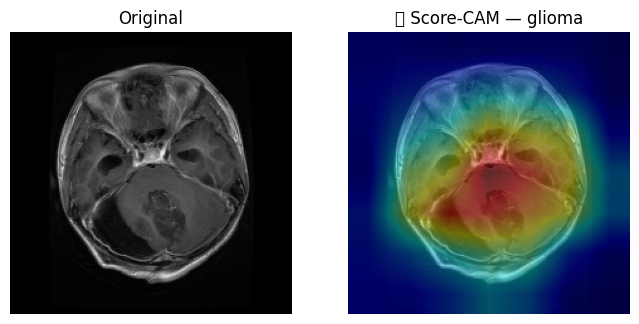

In [14]:
import numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf

# pick one validation image
for imgs, labels in val_ds.take(1):
    img = imgs[0].numpy().astype("uint8")
    break

inp = tf.expand_dims(img, 0)
inp = tf.cast(inp, tf.float32)
inp_pp = tf.keras.applications.resnet50.preprocess_input(inp)

# get the inner ResNet backbone
base_model = model.get_layer("resnet50")
last_conv_layer = "conv5_block3_3_conv"
print(f"✅ Using last conv layer inside ResNet: {last_conv_layer}")

# get activations from that layer
activation_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(last_conv_layer).output
)

# forward pass through backbone
activations = activation_model(inp_pp)[0].numpy()      # shape (7,7,2048)
preds = model.predict(inp_pp, verbose=0)
pred_class = np.argmax(preds[0])

# normalize activations
act_maps = np.maximum(activations, 0)
act_maps = act_maps / (act_maps.max(axis=(0,1)) + 1e-8)

# prepare score map at full image resolution
score_map = np.zeros((224,224), dtype=np.float32)

for i in range(act_maps.shape[-1]):
    # upsample feature map to image size
    upsampled = cv2.resize(act_maps[:,:,i], (224,224))
    upsampled_inp = inp * upsampled[np.newaxis, ..., np.newaxis]
    pred = model.predict(tf.keras.applications.resnet50.preprocess_input(upsampled_inp), verbose=0)
    score_map += upsampled * pred[0, pred_class]

# normalize heatmap to [0,1]
score_map = np.maximum(score_map, 0)
score_map /= (score_map.max() + 1e-8)

# overlay on original image
heat = cv2.applyColorMap(np.uint8(255 * score_map), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img, 0.6, heat, 0.4, 0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay[..., ::-1])
plt.title(f"🔥 Score-CAM — {class_names[pred_class]}")
plt.axis("off")
plt.show()


Predicted class: glioma (0.997)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/tmp/ipython-input-3331949809.py:96: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3331949809.py:96: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3331949809.py:96: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


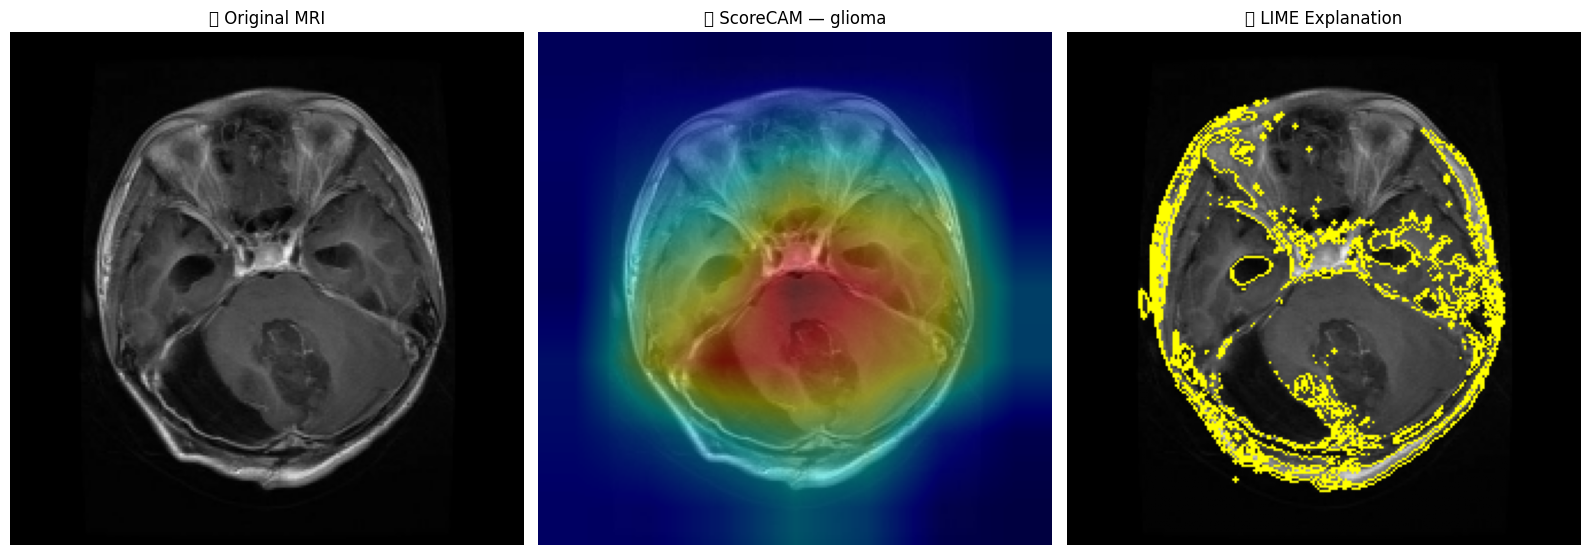

In [15]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2, numpy as np, tensorflow as tf

# pick one image from validation set
for imgs, labels in val_ds.take(1):
    sample_img = imgs[0].numpy().astype("uint8")
    break

# -------------------------
# 🔥 SCORECAM HEATMAP
# -------------------------
inp = tf.expand_dims(sample_img, 0)
inp = tf.cast(inp, tf.float32)
inp_pp = tf.keras.applications.resnet50.preprocess_input(inp)

base_model = model.get_layer("resnet50")
last_conv_layer = "conv5_block3_3_conv"

activation_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(last_conv_layer).output
)

activations = activation_model(inp_pp)[0].numpy()
preds = model.predict(inp_pp, verbose=0)
pred_class = np.argmax(preds[0])
print(f"Predicted class: {class_names[pred_class]} ({preds[0][pred_class]:.3f})")

act_maps = np.maximum(activations, 0)
act_maps = act_maps / (act_maps.max(axis=(0,1)) + 1e-8)

score_map = np.zeros((224,224), dtype=np.float32)
for i in range(act_maps.shape[-1]):
    upsampled = cv2.resize(act_maps[:,:,i], (224,224))
    upsampled_inp = inp * upsampled[np.newaxis, ..., np.newaxis]
    pred = model.predict(tf.keras.applications.resnet50.preprocess_input(upsampled_inp), verbose=0)
    score_map += upsampled * pred[0, pred_class]

score_map = np.maximum(score_map, 0)
score_map /= (score_map.max() + 1e-8)
scorecam_overlay = cv2.addWeighted(
    sample_img, 0.6,
    cv2.applyColorMap(np.uint8(255 * score_map), cv2.COLORMAP_JET),
    0.4, 0
)

# -------------------------
# 💡 LIME EXPLANATION
# -------------------------
explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    imgs = np.array(images, dtype=np.float32)
    imgs = tf.keras.applications.resnet50.preprocess_input(imgs)
    return model.predict(imgs)

explanation = explainer.explain_instance(
    sample_img.astype('double'),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=8,
    hide_rest=False
)

lime_image_vis = mark_boundaries(temp/255.0, mask)

# -------------------------
# 📸 SIDE-BY-SIDE DISPLAY
# -------------------------
plt.figure(figsize=(16,6))

plt.subplot(1,3,1)
plt.imshow(sample_img)
plt.title("🧠 Original MRI")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(scorecam_overlay[..., ::-1])
plt.title(f"🔥 ScoreCAM — {class_names[pred_class]}")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lime_image_vis)
plt.title("💡 LIME Explanation")
plt.axis("off")

plt.tight_layout()
plt.show()


| Method       | What it measures                                       | Type of reasoning                              | Output characteristics            |
| ------------ | ------------------------------------------------------ | ---------------------------------------------- | --------------------------------- |
| **ScoreCAM** | *Feature importance* inside the CNN (activation-based) | "Where in the image the network is looking"    | Smooth heatmap; localized regions |
| **LIME**     | *Input perturbation sensitivity*                       | "Which superpixels change the prediction most" | Segmented mask; boundary-based    |
